# Additional training CV model for balls predictions
## Simple ball prediction. Balls.
Я очень не люблю машинное обучение за то, что нам рассказывают 1203912_3981239047_19203712098_712980379812 штук по применению, которые невозможно грамотно изучить за такой короткий срок. В итоге мы обладаем максимально рандомными знаниями.

Я с таким нежеланием сажусь за выполнение каждого дз, а это мне кажется в 200 раз сложнее, потому что мне не дали ноутбука, где написано, куда и какой код нужно вставить.

## Домашнее задание

В данном задании вам предлагается решить стандартную задачу детекции мячей

1. Выбрать предобученную модель: https://pytorch.org/vision/stable/models.html , https://paperswithcode.com/sota/object-detection-on-coco
2. Создать класс датасета и даталоадера: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
3. Добавить аугментаций: https://pytorch.org/vision/master/transforms.html , https://albumentations.ai/docs/introduction/image_augmentation/
4. Дообучить несколько эпох
5. Рассчитать качество (mAP)

## Data
Данные для семинара можно скачать по ссылке: https://disk.yandex.ru/d/D-q6ahy6j8Jfow

In [139]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import cv2
import seaborn as sns
import json
from torchvision.transforms.functional import resize

import numpy as np
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device is:", device)

Device is: cpu


In [140]:
add_path = "data/seminar_objdet_retina_oi5_ball"
train_annotations_file = f"{add_path}/oi5_ball_filename_to_bbox_train.json"
val_annotations_file = f"{add_path}/oi5_ball_filename_to_bbox_val.json"
image_dir = add_path
predictions_annotation_file = f"{add_path}/oi5_ball_filename_to_bbox_pred.json"
model_save_path = "data/weights.pth"
model_load_path = "data/weights.pth"


In [399]:
def show_image(image, figsize=(10, 10)):
    plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.axis("off")
    plt.show()


def draw_predictions(image, bboxes, scores, classes, class_to_label_map=None, threshold=0.5):
    palette = sns.color_palette(None, len(class_to_label_map))
    image_with_predictions = image.copy()
    
    for bbox, score, class_int in zip(bboxes, scores, classes):
        if score < threshold:
            continue
        
        x1, y1, x2, y2, label = bbox.numpy().astype(np.int32)
        # label = class_to_label_map[class_int.item()]
        # color = palette[class_int.item()]
        label = "Test"
        color = palette[0]
        
        cv2.rectangle(image_with_predictions, (x1, y1), (x2, y2), np.array(color) * 255, 2)
        if class_to_label_map is not None:
            cv2.putText(image_with_predictions, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, np.array(color) * 255, 2)
        
        
    return image_with_predictions


def make_tensor(image, device=None):
    tensor = transforms.functional.to_tensor(image).unsqueeze(0)
    tensor = transforms.functional.normalize(tensor,
                       mean=(0.485, 0.456, 0.406),
                       std=(0.229, 0.224, 0.225))
    if device:
        tensor = tensor.to(device)
    return tensor

Image shape (683, 1024, 3)
Tensor size torch.Size([1, 3, 683, 1024])


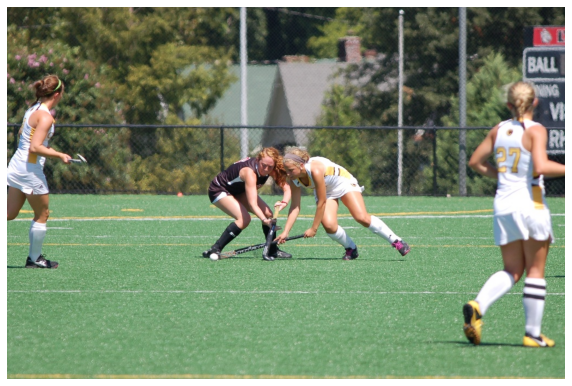

In [142]:
import cv2

for i in range(5, 6):
    image = cv2.imread(f"{add_path}/oi5_ball/000{i}.jpg")
    image_example = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print("Image shape", image_example.shape)

    tensor_example = make_tensor(image_example, device)
    print("Tensor size", tensor_example.size())

    show_image(image_example)

## Выбор предобученной модели

In [143]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Загрузка предобученной модели Faster R-CNN
model = fasterrcnn_resnet50_fpn(pretrained=True)


/home/timofey/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/timofey/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Создание класса датасета и даталоадера

In [358]:
class CustomBallDataset(Dataset):
    def __init__(self, image_dir, annotations_file, transform=None, target_transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.target_transform = target_transform

        with open(annotations_file, "r") as f:
            self.annotations = json.load(f)

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        image_name = list(self.annotations.keys())[idx]
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path).convert("RGB")

        # w, h = image.shape
        w, h = 800, 800

        target = self.annotations[image_name]
        boxes = []
        labels = []

        for bbox in target:
            xmin = bbox[0] * w
            xmax = bbox[1] * w
            ymin = bbox[2] * h
            ymax = bbox[3] * h
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)  # Класс "ball" имеет метку 1


        target = {}
        target["image_id"] = torch.tensor([idx])
        target["boxes"] = torch.tensor(boxes, dtype=torch.float32)
        target["labels"] = torch.tensor(labels, dtype=torch.int64)

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            target = self.target_transform(target)

        return image, target

In [145]:
class ZeroBallDataset(Dataset):
    def __init__(self, image_dir, annotations_file, transform=None):
        self.image_dir = image_dir
        self.annotations = annotations_file
        self.transform = transform
        self.max_objects = 10  # Максимальное количество объектов в каждом изображении
        self.dummy_bbox = [0, 0, 0, 0] 

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        image_name = list(self.annotations.keys())[idx]
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path).convert("RGB")
        w, h = image.size

        target = self.annotations[image_name]
        boxes = []
        labels = []
        num_objects = len(target)

        # Если объектов меньше, чем self.max_objects, добавьте фиктивные аннотации
        for i in range(self.max_objects):
            if i < num_objects:
                annotation = target[i]
                xmin, xmax, ymin, ymax = annotation
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(1)  # Предположим, что все объекты - это мячи
            else:
                # Добавляем фиктивные аннотации
                boxes.append(self.dummy_bbox)
                labels.append(0)  # Фиктивный класс для отсутствующих объектов

        target = {}
        target["image_id"] = torch.tensor([idx])
        target["boxes"] = torch.tensor(boxes, dtype=torch.float32)
        target["labels"] = torch.tensor(labels, dtype=torch.int64)

        if self.transform:
            image = self.transform(image)

        return image, target

## Добавим collate для упаковки в батчи разного числа bbox

In [359]:
def collater(data):
    "Pad data"

    imgs = [s[0] for s in data]  # Извлекаем изображения
    annots = [s[1] for s in data]  # Извлекаем аннотации

    # Определение максимальных размеров изображений в батче
    max_width = max(img.shape[1] for img in imgs)
    max_height = max(img.shape[2] for img in imgs)

    # Создание пустого батча для изображений
    padded_imgs = torch.zeros(len(imgs), 3, max_width, max_height)

    # Создание списка для аннотаций
    annot_list = []

    # Заполнение батча изображений и списка аннотаций
    for i, (img, annot) in enumerate(zip(imgs, annots)):
        c, h, w = img.shape
        # padded_imgs[i, :, :c, :h, :w] = img
        padded_imgs[i, :, :h, :w] = img

        # Преобразование аннотаций в нужный формат
        boxes = annot['boxes']
        labels = annot['labels']
        num_annots = boxes.shape[0]
        annot_padded = torch.cat([boxes, labels.view(-1, 1).float()], dim=1)

        # Добавление аннотаций в список
        annot_list.append(annot_padded)

    # Определение максимального числа аннотаций
    max_num_annots = max(annot.shape[0] for annot in annot_list)

    # Создание пустой матрицы для аннотаций
    annot_padded = torch.ones(len(annots), max_num_annots, 5) * -1

    # Заполнение матрицы аннотаций
    for i, annot in enumerate(annot_list):
        num_annots = annot.shape[0]
        annot_padded[i, :num_annots, :] = annot

    # Перестановка измерений батча изображений
    padded_imgs = padded_imgs.permute(0, 1, 2, 3)

    return padded_imgs, annot_padded


## Добавление аугментаций

In [360]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

def train_transform(image, target):
    image = image.numpy()
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    transform = A.Compose([
        A.RandomResizedCrop(height=300, width=300, scale=(0.8, 1.0)),
        A.HorizontalFlip(p=0.5),
        A.ColorJitter(p=0.2),
        A.Normalize(mean=mean, std=std),
        ToTensorV2()
    ])

    transformed = transform(image=image, bboxes=target["boxes"], labels=target["labels"])
    image = transformed["image"]
    target["boxes"] = transformed["bboxes"]
    target["labels"] = transformed["labels"]

    return image, target


def val_transform(image, target):
    image = image.numpy()
    transform = A.Compose([
        A.Resize(height=800, width=800),
        ToTensorV2()
    ])

    transformed = transform(image=image, bboxes=target["boxes"], labels=target["labels"])
    image = transformed["image"]
    target["boxes"] = transformed["bboxes"]
    target["labels"] = transformed["labels"]

    return image, target

In [412]:
train_transform = transforms.Compose([
    transforms.Resize((800, 800)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


val_transform = transforms.Compose([
    transforms.Resize((800, 800)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Создание датасета
train_dataset = CustomBallDataset(image_dir, train_annotations_file, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True, collate_fn=collater)

val_dataset = CustomBallDataset(image_dir, val_annotations_file, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=12, shuffle=True)


## Тесты

In [413]:
images, targets = train_dataset[0]

In [414]:
images.shape, targets['boxes'].shape, targets['labels'].shape, targets['image_id'].shape

(torch.Size([3, 800, 800]),
 torch.Size([6, 4]),
 torch.Size([6]),
 torch.Size([1]))

In [415]:
images, targets = next(iter(train_loader))

In [416]:
images.shape, targets.shape

(torch.Size([12, 3, 800, 800]), torch.Size([12, 8, 5]))

In [421]:
targets[7].shape, images[9].shape

(torch.Size([8, 5]), torch.Size([3, 800, 800]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


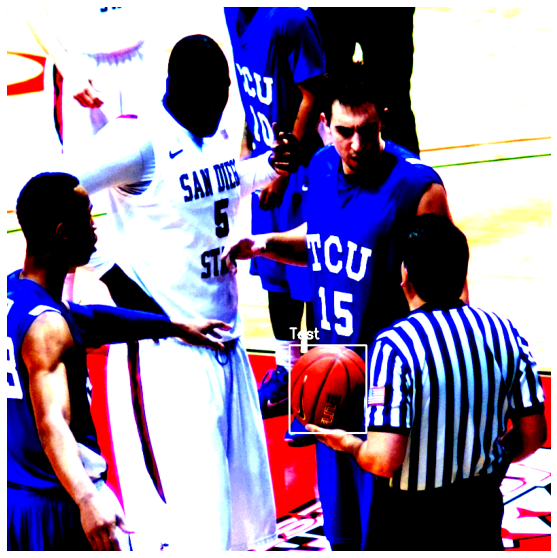

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


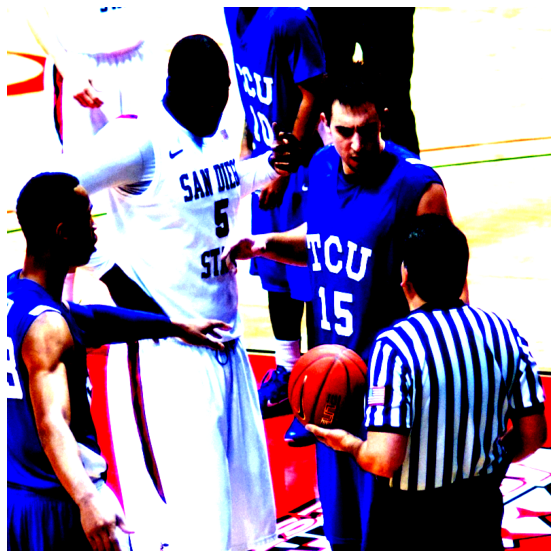

In [424]:
index = 5
image = images[index].permute(1,2,0).numpy()
image_with_predictions = draw_predictions(image, targets[index], scores=[0.7], classes=[{'ball': 1}], class_to_label_map=[1])

show_image(image_with_predictions)
show_image(image)

## Обучение модели

In [437]:
# Изменяем количество классов для детекции (1 класс - мяч)
num_classes = 2  # 1 (мяч) + 1 (фон)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Добавим GPU поддержку, если доступен
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Оптимизатор и функция потерь
# optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
# criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = torch.nn.SmoothL1Loss()

# Обучение модели на нескольких эпохах
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    for images, batched_targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = []

        for batch in batched_targets:
            boxes = batch[:, :4]
            labels = batch[:, -1]

            target = {
                "boxes": boxes,
                "labels": labels
            }

            targets.append(target)
        
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {losses.item()}")

AssertionError: All bounding boxes should have positive height and width. Found invalid box [-1.0, -1.0, -1.0, -1.0] for target at index 0.

In [153]:
# Изменяем количество классов для детекции (1 класс - мяч)
num_classes = 2  # 1 (мяч) + 1 (фон)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Добавим GPU поддержку, если доступен
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Оптимизатор и функция потерь
# optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

# Обучение модели на нескольких эпохах
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    for images, batched_targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = []

        for i in range(len(images)):
            image_id = batched_targets['image_id'][i] 
            boxes = batched_targets['boxes'][i]
            labels = batched_targets['labels'][i]

            target = {
                "boxes": boxes,
                "labels": labels
            }

            target["image_id"] = image_id
            targets.append(target)
        
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {losses.item()}")


KeyboardInterrupt: 

## Это я обучал всю ночь, и в итоге выводился nan Loss. (13.5 часов)
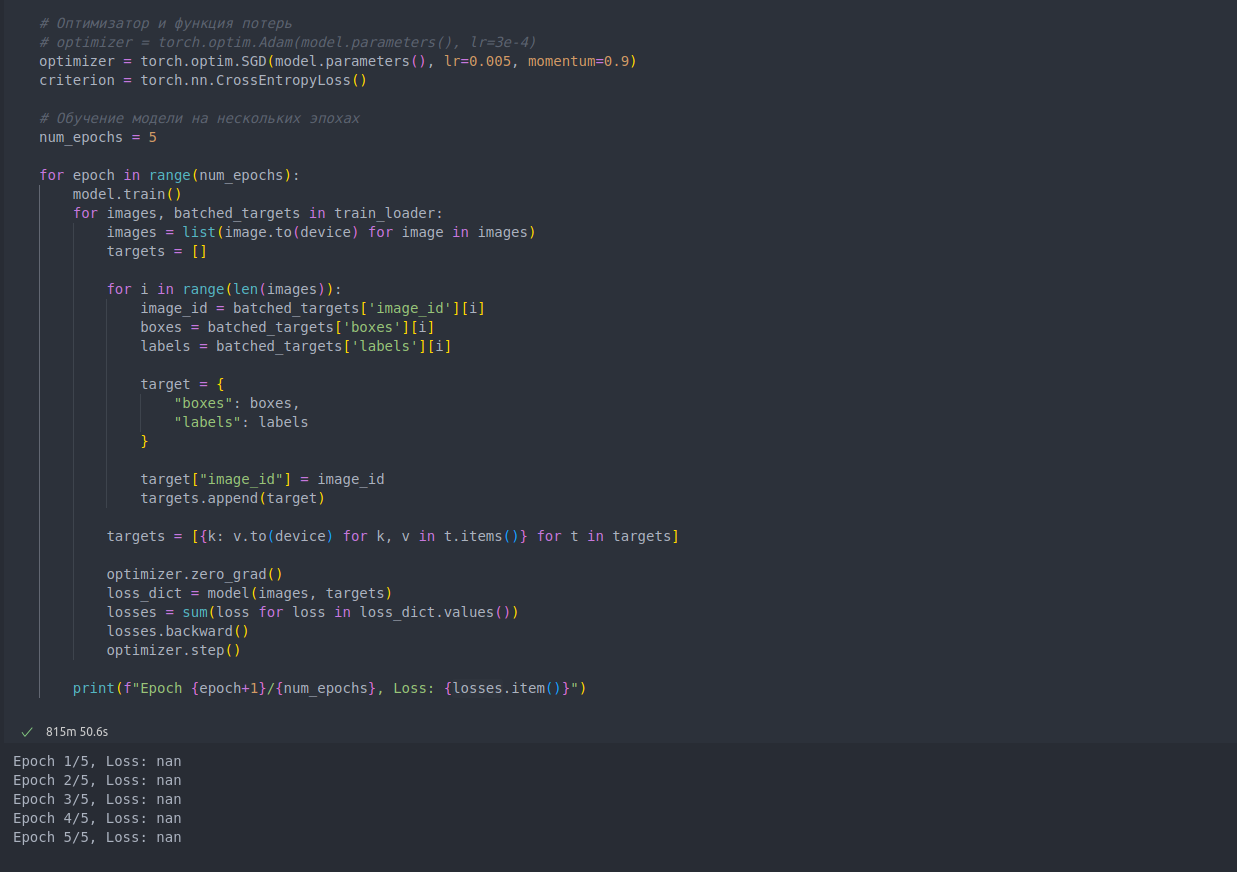

In [ ]:
# Путь, по которому вы хотите сохранить параметры модели
# model_save_path = "data/weights.pth"

# Сохранение параметров модели
# torch.save(model.state_dict(), model_save_path)

# Загрузка параметров модели
# model_load_path = "data/weights.pth"
# model.load_state_dict(torch.load(model_load_path))

## Рассчет качества (mAP)

In [438]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# add_path = "data/seminar_objdet_retina_oi5_ball"
# train_annotations_file = f"{add_path}/oi5_ball_filename_to_bbox_train.json"
# val_annotations_file = f"{add_path}/oi5_ball_filename_to_bbox_val.json"
# image_dir = add_path
# predictions_annotation_file = f"{add_path}/oi5_ball_filename_to_bbox_pred.json"

# Загрузка ground truth аннотаций
coco_gt = COCO(val_annotations_file)

# Создание списка для предсказаний модели в формате COCO
predictions = []
model.eval()
with torch.no_grad():
    for images, batched_targets in val_loader:
        images = list(image.to(device) for image in images)
        predictions_batch = model(images)
        for i in range(len(images)):
            image_id = batched_targets['image_id'][i].item()
            prediction = predictions_batch[i]
            boxes = prediction["boxes"].cpu().numpy()
            scores = prediction["scores"].cpu().numpy()
            labels = prediction["labels"].cpu().numpy()

            for box, score, label in zip(boxes, scores, labels):
                predictions.append({
                    "image_id": image_id,
                    "category_id": label,
                    "bbox": [float(coord) for coord in box],
                    "score": float(score)
                })

# Сохранение предсказаний в формате COCO
with open(predictions_annotation_file, "w") as f:
    json.dump(predictions, f)

# Загрузка предсказаний для оценки
coco_dt = coco_gt.loadRes(predictions_annotation_file)

# Выполнение оценки
coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


RuntimeError: stack expects each tensor to be equal size, but got [1, 4] at entry 0 and [5, 4] at entry 2

## Посмотрим на предсказания

In [439]:
model.eval()
with torch.no_grad():
    for i in range(28, 35):
        images, targets = train_dataset[i]
        predictions_batch = model([images])
        print(f"{i} iteration")
        if len(predictions_batch[0]['boxes']) > 0:
            image = images.permute(1,2,0).numpy()
            image_trust = draw_predictions(image, targets['boxes'], scores=[0.7], classes=[{'ball': 1}], class_to_label_map=[1])
            show_image(image_trust)

            image_with_predictions = draw_predictions(image, predictions_batch[0]['boxes'], scores=predictions_batch[0]['scores'], classes=[{'ball': 1}], class_to_label_map=predictions_batch[0]['labels'], threshold=0.01)
            show_image(image_with_predictions)
            print(predictions_batch[0])

28 iteration


ValueError: not enough values to unpack (expected 5, got 4)